In [1]:
import warnings
warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time

In [42]:
#本次的假设为根据图像选出KDJ指标阈值后，金叉买死叉卖

In [2]:
#选取BTCUSDT：binance为数据对象，并添加freq参数
start = time()
path = r'C:\Users\风袖\Downloads\min_data\VnTrader_1Min_Db'
props = {'fields':'high,low,close,open,volume',
         'symbol': 'BTCUSDT:binance',
         'freq':'30min,1h',
         'start_date': 20180601000000}

Time_dict = ds.bar_reader(path, props)#读取数据

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1h = HFDataView()
dv1h.create_init_dv(Time_dict['1h'].dropna().set_index(["trade_date","symbol"]))
dv1h.get_ts('close',date_type='datetime').head()
import pandas as pd
import matplotlib.pyplot as plt

Initialize dataview success.


In [5]:
#以KDJ为对象
def Plot_Mean(dv, KDJ_K_A, KDJ_D_A, KDJ_J_A, chart_name='KDJ',ShortPeriod=20, LongPeriod=60,n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(KDJ_K_A.iloc[n:], alpha=0.4,c='blue')
    ax1.plot(KDJ_D_A.iloc[n:], alpha=0.4,c='orange')
    ax1.plot(KDJ_J_A.iloc[n:], alpha=0.4,c='green')
    ax1.hlines(0.3, RSV.iloc[n:].index[0], RSV.iloc[n:].index[-1], alpha=0.4, linestyle='--')
    ax1.hlines(0.7, RSV.iloc[n:].index[0], RSV.iloc[n:].index[-1], alpha=0.4, linestyle='--')
    # plt.savefig(chart_name)
    plt.show()

def SMA(A,n,m):
        # 设置alpha的比例
        alpha = m/n
        #通过ewm计算递归函数
        return A.ewm(alpha=alpha, adjust=False).mean()
dv1h.add_formula('RSV',"(close-Ts_Min(low,9))/(Ts_Max(high,9)-Ts_Min(low,9))",add_data=True)
dv1h.add_formula('KDJ_K_A',"SMA(RSV,{},{})".format(3,1), add_data=True,register_funcs={"SMA":SMA})
dv1h.add_formula('KDJ_D_A',"SMA(KDJ_K_A,{},{})".format(3,1), add_data=True,register_funcs={"SMA":SMA})
dv1h.add_formula('KDJ_J_A',"{}*KDJ_K_A - {}*KDJ_D_A".format(3,2), add_data=True)

Field [RSV] is overwritten.
Field [KDJ_K_A] is overwritten.
Field [KDJ_D_A] is overwritten.
Field [KDJ_J_A] is overwritten.


symbol,BTCUSDT:binance
trade_date,
20180601000000,NaN
20180601010000,NaN
20180601020000,NaN
20180601030000,NaN
20180601040000,NaN
20180601050000,NaN
20180601060000,NaN
20180601070000,NaN
20180601080000,0.350145


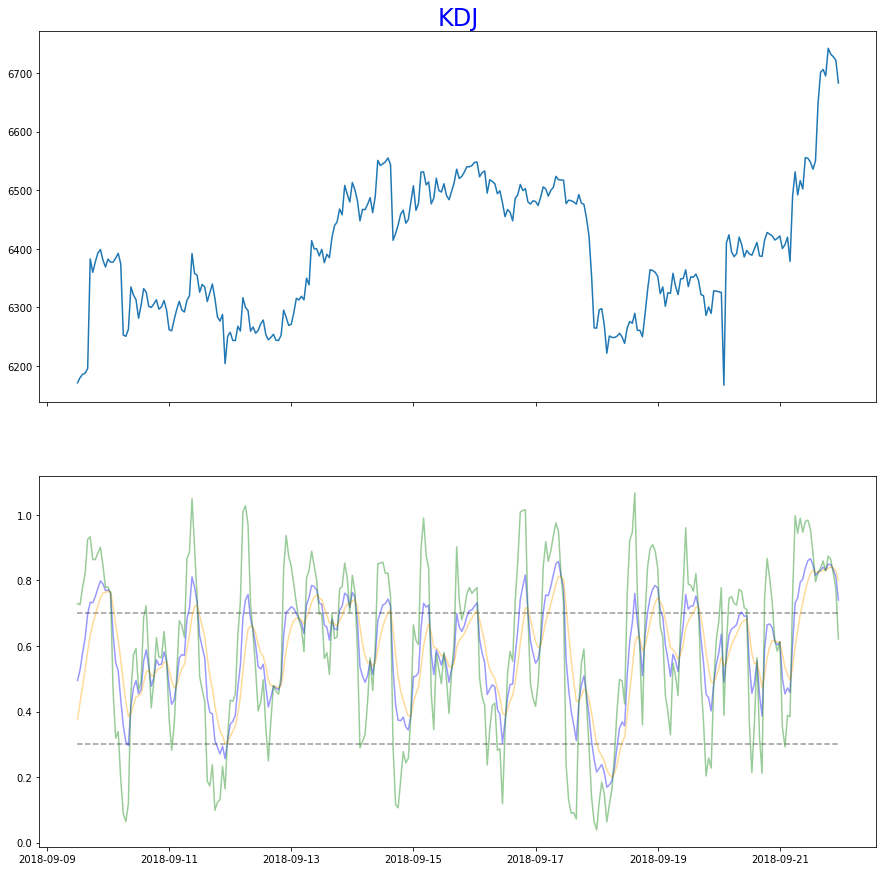

In [6]:
KDJ_K_A = dv1h.get_ts('KDJ_K_A', date_type='datetime')
KDJ_D_A = dv1h.get_ts('KDJ_D_A', date_type='datetime')
KDJ_J_A = dv1h.get_ts('KDJ_J_A', date_type='datetime')
close = dv1h.get_ts('close',date_type='datetime')
RSV = dv1h.get_ts('RSV', date_type='datetime')

Plot_Mean(dv1h, KDJ_K_A.iloc[:,0], KDJ_D_A.iloc[:,0], KDJ_J_A.iloc[:,0],n=-300)

In [27]:
# 进场信号
long = dv1h.add_formula("longKDJ","If(((KDJ_K_A>KDJ_D_A) && (Delay(KDJ_K_A<KDJ_D_A,1)))||(KDJ_J_A>0.3 && (Delay(KDJ_J_A<0.3,1))),2,0)",add_data=True)
short = dv1h.add_formula("shortKDJ","If(((KDJ_K_A<KDJ_D_A) && (Delay(KDJ_K_A>KDJ_D_A,1)))||(KDJ_J_A<0.6 && (Delay(KDJ_J_A>0.6,1))),-2,0)",add_data=True)

# 出场信号
close_long = dv1h.add_formula("closeLongKDJ","If(shortKDJ==-2,1,0)", add_data=True)
close_short = dv1h.add_formula("closeShortKDJ","If(longKDJ==2,-1,0)", add_data=True)

Field [longKDJ] is overwritten.
Field [shortKDJ] is overwritten.
Field [closeLongKDJ] is overwritten.
Field [closeShortKDJ] is overwritten.


In [28]:
from jaqs_fxdayu.research import TimingDigger
Statistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='Statistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    td.process_signal(
        enter_signal=dv.get_ts("longKDJ"),
        exit_signal=dv.get_ts("closeLongKDJ"),
        sig_type="long",  # 信号类型 long
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("shortKDJ"),
        exit_signal=dv.get_ts("closeShortKDJ"),
        sig_type="short",  # 信号类型 short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(Statistic, dv1h, 100, 0.15, 0.7)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 12%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 12%


In [29]:
Statistic.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               10.814  -16.135   -1.228
p-value               0.000    0.000    0.220
mean                  0.012   -0.008   -0.001
std                   0.017    0.010    0.016
info_ratio            0.694   -0.799   -0.048
skewness              2.596   -2.812    1.313
kurtosis              7.446    9.931    8.742
pct5                  0.000   -0.029   -0.021
pct25                 0.002   -0.010   -0.006
pct50                 0.006   -0.004   -0.002
pct75                 0.012   -0.002    0.003
pct95                 0.047   -0.000    0.026
occurance           244.000  409.000  653.000
win_ratio               NaN      NaN    0.374
win_mean/loss_mean      NaN      NaN    1.421


In [30]:
Statistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                7.621  -13.043   -0.147
p-value               0.000    0.000    0.883
mean                  0.013   -0.008   -0.000
std                   0.019    0.009    0.017
info_ratio            0.702   -0.913   -0.008
skewness              2.130   -2.253    1.913
kurtosis              4.265    5.610    7.693
pct5                  0.000   -0.027   -0.020
pct25                 0.002   -0.009   -0.006
pct50                 0.005   -0.005   -0.002
pct75                 0.015   -0.003    0.002
pct95                 0.052   -0.001    0.029
occurance           119.000  205.000  324.000
win_ratio               NaN      NaN    0.367
win_mean/loss_mean      NaN      NaN    1.675


In [31]:
Statistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                7.788  -10.453   -1.614
p-value               0.000    0.000    0.108
mean                  0.010   -0.009   -0.001
std                   0.015    0.012    0.016
info_ratio            0.699   -0.734   -0.089
skewness              3.252   -2.850    0.641
kurtosis             13.269    9.449    9.730
pct5                  0.000   -0.033   -0.023
pct25                 0.002   -0.011   -0.005
pct50                 0.006   -0.004   -0.002
pct75                 0.011   -0.002    0.003
pct95                 0.041   -0.000    0.022
occurance           125.000  204.000  329.000
win_ratio               NaN      NaN    0.380
win_mean/loss_mean      NaN      NaN    1.199


In [32]:
#综合来看胜率均低于0.4，但win_mean/win_loss均大于1

In [33]:
#选取EOSUSDT：binance为数据对象，并添加freq参数
start = time()
path = r'C:\Users\风袖\Downloads\min_data\VnTrader_1Min_Db'
props = {'fields':'high,low,close,open,volume',
         'symbol': 'EOSUSDT:binance',
         'freq':'30min,1h',
         'start_date': 20180601000000}

Time_dict = ds.bar_reader(path, props)#读取数据

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1h = HFDataView()
dv1h.create_init_dv(Time_dict['1h'].dropna().set_index(["trade_date","symbol"]))
dv1h.get_ts('close',date_type='datetime').head()
import pandas as pd
import matplotlib.pyplot as plt

Initialize dataview success.


In [34]:
def Plot_Mean(dv, KDJ_K_A, KDJ_D_A, KDJ_J_A, chart_name='KDJ',ShortPeriod=20, LongPeriod=60,n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(KDJ_K_A.iloc[n:], alpha=0.4,c='blue')
    ax1.plot(KDJ_D_A.iloc[n:], alpha=0.4,c='orange')
    ax1.plot(KDJ_J_A.iloc[n:], alpha=0.4,c='green')
    ax1.hlines(0.3, RSV.iloc[n:].index[0], RSV.iloc[n:].index[-1], alpha=0.4, linestyle='--')
    ax1.hlines(0.7, RSV.iloc[n:].index[0], RSV.iloc[n:].index[-1], alpha=0.4, linestyle='--')
    # plt.savefig(chart_name)
    plt.show()

def SMA(A,n,m):
        # 设置alpha的比例
        alpha = m/n
        #通过ewm计算递归函数
        return A.ewm(alpha=alpha, adjust=False).mean()
dv1h.add_formula('RSV',"(close-Ts_Min(low,9))/(Ts_Max(high,9)-Ts_Min(low,9))",add_data=True)
dv1h.add_formula('KDJ_K_A',"SMA(RSV,{},{})".format(3,1), add_data=True,register_funcs={"SMA":SMA})
dv1h.add_formula('KDJ_D_A',"SMA(KDJ_K_A,{},{})".format(3,1), add_data=True,register_funcs={"SMA":SMA})
dv1h.add_formula('KDJ_J_A',"{}*KDJ_K_A - {}*KDJ_D_A".format(3,2), add_data=True)

symbol,EOSUSDT:binance
trade_date,
20180601000000,NaN
20180601010000,NaN
20180601020000,NaN
20180601030000,NaN
20180601040000,NaN
20180601050000,NaN
20180601060000,NaN
20180601070000,NaN
20180601080000,0.256903


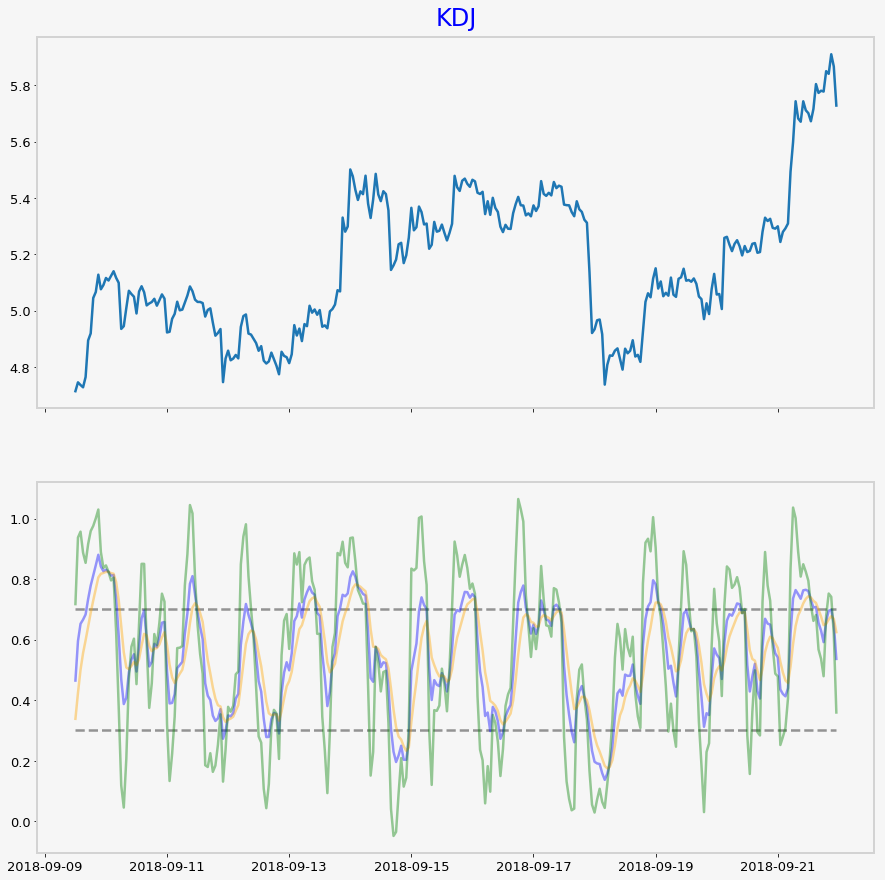

In [35]:
KDJ_K_A = dv1h.get_ts('KDJ_K_A', date_type='datetime')
KDJ_D_A = dv1h.get_ts('KDJ_D_A', date_type='datetime')
KDJ_J_A = dv1h.get_ts('KDJ_J_A', date_type='datetime')
close = dv1h.get_ts('close',date_type='datetime')
RSV = dv1h.get_ts('RSV', date_type='datetime')

Plot_Mean(dv1h, KDJ_K_A.iloc[:,0], KDJ_D_A.iloc[:,0], KDJ_J_A.iloc[:,0],n=-300)

In [36]:
# 进场信号
long = dv1h.add_formula("longKDJ","If(((KDJ_K_A>KDJ_D_A) && (Delay(KDJ_K_A<KDJ_D_A,1)))||(KDJ_J_A>0.3 && (Delay(KDJ_J_A<0.3,1))),2,0)",add_data=True)
short = dv1h.add_formula("shortKDJ","If(((KDJ_K_A<KDJ_D_A) && (Delay(KDJ_K_A>KDJ_D_A,1)))||(KDJ_J_A<0.8 && (Delay(KDJ_J_A>0.8,1))),-2,0)",add_data=True)

# 出场信号
close_long = dv1h.add_formula("closeLongKDJ","If(shortKDJ==-2,1,0)", add_data=True)
close_short = dv1h.add_formula("closeShortKDJ","If(longKDJ==2,-1,0)", add_data=True)

In [37]:
from jaqs_fxdayu.research import TimingDigger
Statistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='Statistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    td.process_signal(
        enter_signal=dv.get_ts("longKDJ"),
        exit_signal=dv.get_ts("closeLongKDJ"),
        sig_type="long",  # 信号类型 long
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("shortKDJ"),
        exit_signal=dv.get_ts("closeShortKDJ"),
        sig_type="short",  # 信号类型 short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(Statistic, dv1h, 100, 0.15, 0.7)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 11%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 11%


In [38]:
Statistic.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               11.574  -17.710   -0.797
p-value               0.000    0.000    0.426
mean                  0.023   -0.018   -0.001
std                   0.032    0.019    0.032
info_ratio            0.738   -0.944   -0.033
skewness              2.409   -2.250    1.306
kurtosis              5.691    6.938    6.268
pct5                  0.001   -0.056   -0.047
pct25                 0.005   -0.024   -0.015
pct50                 0.012   -0.012   -0.003
pct75                 0.026   -0.005    0.008
pct95                 0.096   -0.001    0.050
occurance           247.000  353.000  600.000
win_ratio               NaN      NaN    0.412
win_mean/loss_mean      NaN      NaN    1.288


In [39]:
Statistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.312  -13.252   -1.125
p-value               0.000    0.000    0.262
mean                  0.024   -0.016   -0.002
std                   0.029    0.017    0.029
info_ratio            0.811   -0.969   -0.066
skewness              2.090   -1.894    1.300
kurtosis              4.381    3.809    5.347
pct5                  0.001   -0.055   -0.046
pct25                 0.005   -0.021   -0.015
pct50                 0.012   -0.010   -0.004
pct75                 0.029   -0.005    0.007
pct95                 0.087   -0.001    0.046
occurance           106.000  188.000  294.000
win_ratio               NaN      NaN    0.361
win_mean/loss_mean      NaN      NaN    1.447


In [40]:
Statistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.207  -12.111   -0.114
p-value               0.000    0.000    0.909
mean                  0.023   -0.020   -0.000
std                   0.034    0.022    0.035
info_ratio            0.694   -0.946   -0.007
skewness              2.538   -2.302    1.262
kurtosis              6.003    7.076    6.180
pct5                  0.001   -0.059   -0.048
pct25                 0.005   -0.029   -0.015
pct50                 0.011   -0.013   -0.002
pct75                 0.025   -0.006    0.009
pct95                 0.114   -0.002    0.052
occurance           141.000  165.000  306.000
win_ratio               NaN      NaN    0.461
win_mean/loss_mean      NaN      NaN    1.146


In [41]:
#三组win_mean/loss_mean均大于1，但long组胜率小于0.4

#综合两组数据结果来看，KDJ指标可以运用于灵活判断KDJ阈值后金叉买死叉卖的策略，但胜率普遍低于0.4